### LSTM model
#### using the LSTM architecture to predict litter moisture. First, we trained the model with manually selected hyperparameters, then using the Optun framework, we searched for hyperparameters to find the best perforating architecture.

In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import optuna
import tensorflow as tf
from litter import WindowGenerator
from matplotlib.gridspec import GridSpec
from optuna.integration import TFKerasPruningCallback
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("bmh")

In [4]:
# WindowGenerator params
DATA_PATH = "../stations"
SCALING = "standarization"  # secont option: 'normalization'
GAP_STRATEGY = "linear"
FIRST_SEASON = 2015
FIRST_VAL_SEASON = 2021
FIRST_TEST_SEASON = 2022
LAST_TEST_SEASON = 2022

# data generator params
FEATURES = [
    "air_temperature_50cm",
    "air_temperature_200cm",
    "air_humidity_50cm",
    "air_humidity_200cm",
    "wind_x",
    "wind_y",
    "max_wind_x",
    "max_wind_y",
    "temporary_rainfall",
    "total_precipitation",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]
DATA_FORMAT = "channels_last"
INTERVALS = [3, 6, 6 * 2, 6 * 4, 6 * 24, 6 * 24 * 12]
BASE_SEQ_LEN = 30
OTHER_SEQ_LEN = [30, 30, 30, 30, 30, 30]
INCLUDE_COORDS = True
USE_PREVIOUS_Y = True
REPLACE = False

# training params
BATCH_SIZE = 32

In [5]:
wg = WindowGenerator(
    data_path=DATA_PATH,
    scaling=SCALING,
    gap_strategy=GAP_STRATEGY,
    first_train_season=FIRST_SEASON,
    first_val_season=FIRST_VAL_SEASON,
    first_test_season=FIRST_TEST_SEASON,
    last_test_season=LAST_TEST_SEASON,
)

In [6]:
(train_x, train_y), (val_x, val_y), (test_x, test_y), length_stats = wg.get_data(
    batch_size=BATCH_SIZE,
    data_format=DATA_FORMAT,
    intervals=INTERVALS,
    base_seq_len=BASE_SEQ_LEN,
    other_seq_len=OTHER_SEQ_LEN,
    features_cols=FEATURES,
    include_coords=INCLUDE_COORDS,
    use_previous_y=USE_PREVIOUS_Y,
    replace=REPLACE,
    train_generator=False,
    val_generator=False,
    test_generator=False,
)

data format: channels_last
641
641 641 641
370
370 370 370
1586
1586 1586 1586
1324
1324 1324 1324
1673
1673 1673 1673
1279
1279 1279 1279
711
711 711 711
431
431 431 431
266
266 266 266
219
219 219 219
1945
1945 1945 1945
1209
1209 1209 1209
1407
1407 1407 1407
966
966 966 966
1033
1033 1033 1033
0
0 0 0
879
879 879 879
505
505 505 505
1197
1197 1197 1197
750
750 750 750
868
868 868 868
608
608 608 608
875
875 875 875
550
550 550 550
1617
1617 1617 1617
1126
1126 1126 1126
2035
2035 2035 2035
1673
1673 1673 1673
1993
1993 1993 1993
1225
1225 1225 1225
1968
1968 1968 1968
1240
1240 1240 1240
1107
1107 1107 1107
767
767 767 767
2006
2006 2006 2006
1409
1409 1409 1409
1834
1834 1834 1834
1074
1074 1074 1074
165
165 165 165
69
69 69 69
1178
1178 1178 1178
532
532 532 532
1603
1603 1603 1603
1028
1028 1028 1028
1879
1879 1879 1879
907
907 907 907
1327
1327 1327 1327
766
766 766 766
1774
1774 1774 1774
1091
1091 1091 1091
1889
1889 1889 1889
1270
1270 1270 1270
2009
2009 2009 2009
1589
1589

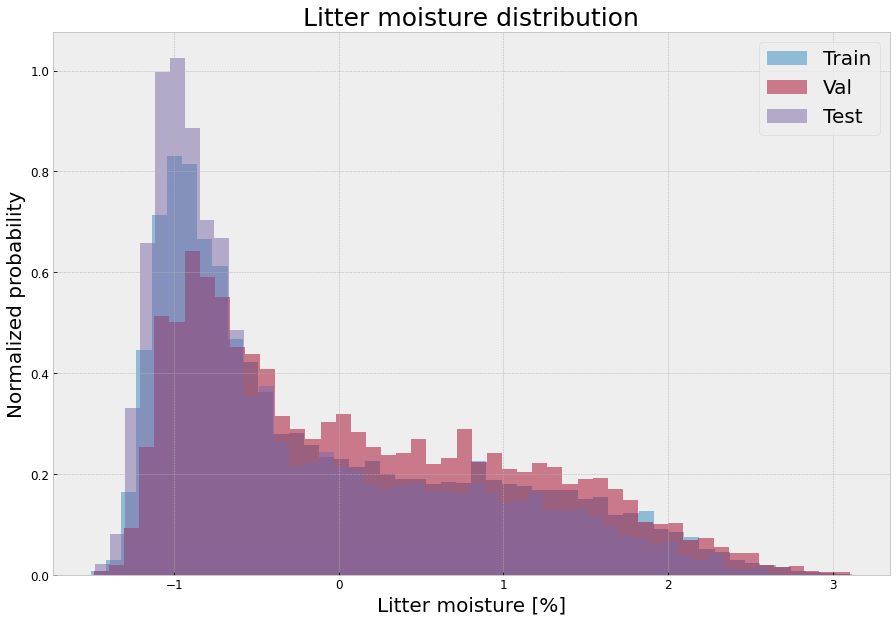

In [7]:
fig, ax = plt.subplots()

ax.hist(train_y, bins=50, density=True, label="Train", alpha=0.5)
ax.hist(val_y, bins=50, density=True, label="Val", alpha=0.5)
ax.hist(test_y, bins=50, density=True, label="Test", alpha=0.5)

plt.title("Litter moisture distribution", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Litter moisture [%]", fontsize=20)
ax.set_ylabel("Normalized probability", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_distribution_lstm.svg")

In [8]:
if SCALING == "normalization":
    train_y = (
        (wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]) * train_y
    ) + wg.train_min["litter_moisture"]
    val_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_y + wg.train_min["litter_moisture"]
    test_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_y + wg.train_min["litter_moisture"]

    y_morning_train = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * train_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_val = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_test = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_x[0][:, 0] + wg.train_min["litter_moisture"]

elif SCALING == "standarization":
    train_y = (
        train_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    )
    val_y = val_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    test_y = test_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]

    y_morning_train = (
        train_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_val = (
        val_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_test = (
        test_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )

else:
    y_morning_train = train_x[0][:, 0]
    y_morning_val = val_x[0][:, 0]
    y_morning_test = test_x[0][:, 0]

pct_change_train = (train_y - y_morning_train) / y_morning_train * 100
pct_change_val = (val_y - y_morning_val) / y_morning_val * 100
pct_change_test = (test_y - y_morning_test) / y_morning_test * 100

pct_change_mean = pct_change_train.mean()
pct_change_std = pct_change_train.std()

pct_change_standarized_train = (pct_change_train - pct_change_mean) / pct_change_std
pct_change_standarized_val = (pct_change_val - pct_change_mean) / pct_change_std
pct_change_standarized_test = (pct_change_test - pct_change_mean) / pct_change_std

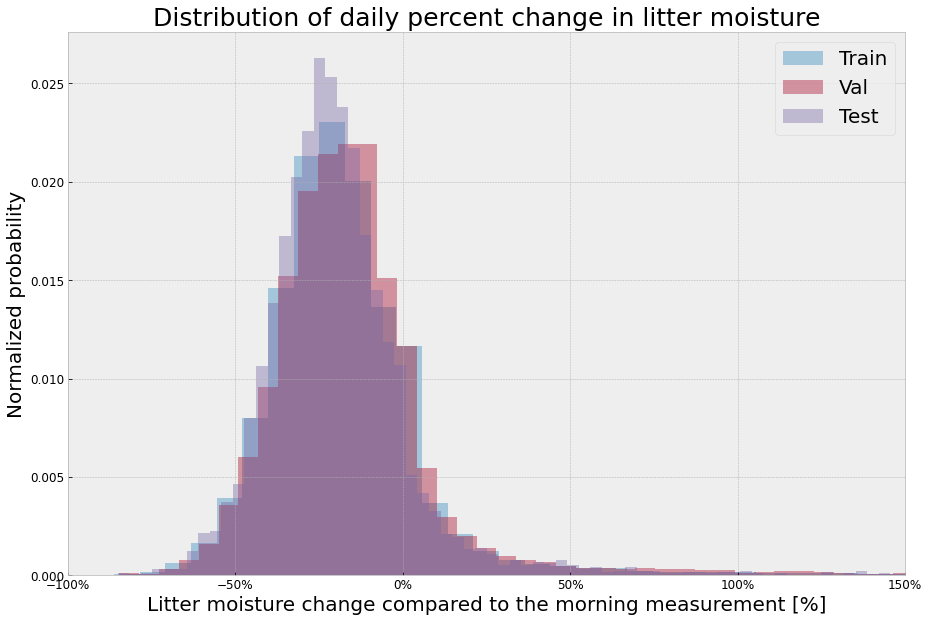

In [9]:
fig, ax = plt.subplots()

ax.hist(pct_change_train, bins=150, density=True, label="Train", alpha=0.4)
ax.hist(pct_change_val, bins=150, density=True, label="Val", alpha=0.4)
ax.hist(pct_change_test, bins=150, density=True, label="Test", alpha=0.4)

plt.xlim([-100, 150])
plt.title("Distribution of daily percent change in litter moisture", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.set_xlabel(
    "Litter moisture change compared to the morning measurement [%]", fontsize=20
)
ax.set_ylabel("Normalized probability", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_change_lstm.svg")

In [ ]:
def get_lstm_model():

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    lstm_blocks = []
    for i, sequence_input in enumerate(sequence_inputs):
        lstm_1 = tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            name=f"lstm_{str(i)}_1",
            recurrent_dropout=0,
            dropout=0.5,
        )

        lstm_2 = tf.keras.layers.LSTM(
            128,
            return_sequences=True,
            name=f"lstm_{str(i)}_2",
            recurrent_dropout=0,
            dropout=0.5,
        )

        lstm_3 = tf.keras.layers.LSTM(
            128,
            return_sequences=False,
            name=f"lstm_{str(i)}_3",
            recurrent_dropout=0,
            dropout=0.5,
        )

        x = lstm_1(sequence_input)
        x = lstm_2(x)
        x = lstm_3(x)
        lstm_blocks.append(x)

    # concatenate all lstm_blocks, and optionally dense data
    if dense_inputs is not None:
        concat = tf.keras.layers.concatenate(
            [dense_inputs, *lstm_blocks], name="concatenate"
        )
    else:
        concat = tf.keras.layers.concatenate(lstm_blocks, name="concatenate")

    dense1 = tf.keras.layers.Dense(128, activation="relu")(concat)
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    dense2 = tf.keras.layers.Dense(32, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

    outputs = tf.keras.layers.Dense(1)(dropout2)
    if dense_inputs is not None:
        model = tf.keras.models.Model(
            inputs=[dense_inputs, *sequence_inputs], outputs=outputs
        )
    else:
        model = tf.keras.models.Model(inputs=sequence_inputs, outputs=outputs)
    return model

In [ ]:
model = get_lstm_model()
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    "model.png",
    show_shapes=True,
    show_dtype=True,
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss=tf.keras.losses.Huber(0.65),
)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
    x=train_x,
    y=pct_change_standarized_train,
    epochs=500,
    validation_data=(val_x, pct_change_standarized_val),
    callbacks=[es],
)

1904/1904 [==============================] - 69s 36ms/step - loss: 0.1524 - val_loss: 0.1513
Epoch 6/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1500 - val_loss: 0.1469
Epoch 7/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1469 - val_loss: 0.1529
Epoch 8/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1457 - val_loss: 0.1525
Epoch 9/500
1904/1904 [==============================] - 70s 37ms/step - loss: 0.1447 - val_loss: 0.1440
Epoch 10/500
1904/1904 [==============================] - 69s 36ms/step - loss: 0.1431 - val_loss: 0.1449
Epoch 11/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1419 - val_loss: 0.1420
Epoch 12/500
1904/1904 [==============================] - 69s 36ms/step - loss: 0.1394 - val_loss: 0.1404
Epoch 13/500
1904/1904 [==============================] - 71s 37ms/step - loss: 0.1391 - val_loss: 0.1440
Epoch 14/500
1904/1904 [==============================] - 71s 3

In [ ]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

In [ ]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

In [ ]:
# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"LSTM model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.05)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=100, density=True)
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)

error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=25, density=True)
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)

In [ ]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(y_real, y_pred, c=z, s=100, alpha=0.5)
ax_hist_x.hist(y_real, orientation="horizontal", bins=50, density=True)
ax_hist_y.hist(y_pred, bins=50, density=True)

plt.show()

In [ ]:
_ = plt.hist(y_real, bins=50, density=True, alpha=0.5)
_ = plt.hist(y_pred, bins=50, density=True, alpha=0.5)

In [ ]:
tf.keras.models.save_model(model, "best_custom_lstm_pct_std")

In [ ]:
def create_model(trial):

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    # We optimize the numbers of layers, their units, dropout ratio and weight decay parameter.
    n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 4)
    n_dense_layers = trial.suggest_int("n_dense_layers", 0, 3)

    lstm_blocks = []
    for i, sequence_input in enumerate(sequence_inputs):
        x = sequence_input
        for j in range(n_lstm_layers):
            return_sequences = j != n_lstm_layers - 1
            is_bidirectional = trial.suggest_categorical(
                "is_bidirectional_lstm_{}_{}".format(i, j), [True, False]
            )
            num_lstm = trial.suggest_categorical(
                "n_units_lstm_{}_{}".format(i, j), [32, 64, 128, 256]
            )
            dropout_rate = trial.suggest_float(
                "dropout_ratio_lstm_{}_{}".format(i, j), 0.0, 0.6
            )
            recurrent_dropout_rate = trial.suggest_float(
                "recurrent_dropout_ratio_lstm_{}_{}".format(i, j), 0.0, 0.3
            )
            lstm_layer = tf.keras.layers.LSTM(
                num_lstm,
                return_sequences=return_sequences,
                name=f"lstm_{str(i)}_{str(j)}",
                dropout=dropout_rate,
            )
            if is_bidirectional:
                x = tf.keras.layers.Bidirectional(lstm_layer)(x)
            else:
                x = lstm_layer(x)

    lstm_blocks.append(x)

    # concatenate all lstm_blocks, and optionally dense data
    if dense_inputs is not None:
        x = tf.keras.layers.concatenate(
            [dense_inputs, *lstm_blocks], name="concatenate"
        )
    else:
        x = tf.keras.layers.concatenate(lstm_blocks, name="concatenate")

    for i in range(n_dense_layers):
        num_hidden = trial.suggest_categorical(
            "n_units_l{}".format(i), [32, 64, 128, 256, 512]
        )
        dropout_rate = trial.suggest_float("dropout_ratio_l{}".format(i), 0.0, 0.5)
        dense = tf.keras.layers.Dense(
            num_hidden,
            activation="relu",
        )
        dropout = tf.keras.layers.Dropout(dropout_rate)
        x = dense(x)
        x = dropout(x)

    if not n_dense_layers:
        dropout_rate = trial.suggest_float("dropout_ratio_output", 0.0, 0.5)
        dropout = tf.keras.layers.Dropout(dropout_rate)
        x = dropout(x)

    outputs = tf.keras.layers.Dense(1)(x)
    if dense_inputs is not None:
        model = tf.keras.models.Model(
            inputs=[dense_inputs, *sequence_inputs], outputs=outputs
        )
    else:
        model = tf.keras.models.Model(inputs=sequence_inputs, outputs=outputs)
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float(
            "rmsprop_momentum", 5 * 1e-5, 1e-1, log=True
        )
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float(
            "adam_learning_rate", 5 * 1e-5, 1e-1, log=True
        )
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float(
            "sgd_opt_momentum", 5 * 1e-5, 1e-1, log=True
        )

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [ ]:
# TODO
# The method of saving to file is not the best idea,
# but for experimental purposes it is sufficient and the fastest in implementation.
# Unfortunately, there are no convenient methods to store information about the best value obtained in the optuna "trial" variable.
f = open("best_mdape_lstm_pct_std.txt", "w")
f.write("10000")
f.close()

In [ ]:
def objective(trial):

    model = create_model(trial)
    optimizer = create_optimizer(trial)
    batch_size = optimizer_selected = trial.suggest_categorical("batch_size", [32, 64])
    delta = 1.35

    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta))

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=7,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    pruner_callback = TFKerasPruningCallback(trial, "val_loss")

    history = model.fit(
        x=train_x,
        y=pct_change_standarized_train,
        batch_size=batch_size,
        epochs=500,
        validation_data=(val_x, pct_change_standarized_val),
        callbacks=[es, pruner_callback],
    )

    val_predictions = model.predict(val_x).flatten()
    pct_change_predicted = val_predictions * pct_change_std + pct_change_mean

    y_real = y_morning_val * (1 + pct_change_val / 100)
    y_pred = y_morning_val * (1 + pct_change_predicted / 100)

    mae = np.absolute(y_real - y_pred).mean()
    rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
    mape = np.abs((y_real - y_pred) / y_real).mean() * 100
    mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
    print(
        f"LSTM pct std model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%"
    )

    f = open("best_mdape_lstm_pct_std.txt", "r")
    best_mdape = float(f.read())
    f.close()

    if mdape < best_mdape:
        print("save model")
        best_mdape = mdape
        tf.keras.models.save_model(model, "best_mdape_lstm_pct_std")
        f = open("best_mdape_lstm_pct_std.txt", "w")
        f.write(str(best_mdape))
        f.close()
    return mdape

In [ ]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=15),
)

In [ ]:
study.optimize(objective, n_trials=100)

952/952 [==============================] - 13s 14ms/step - loss: 0.2672 - val_loss: 0.3152
Epoch 15/500
952/952 [==============================] - 13s 13ms/step - loss: 0.2662 - val_loss: 0.3139
Epoch 16/500
952/952 [==============================] - 13s 14ms/step - loss: 0.2658 - val_loss: 0.3174
Epoch 17/500
952/952 [==============================] - 13s 14ms/step - loss: 0.2652 - val_loss: 0.3148
Epoch 18/500
952/952 [==============================] - 13s 13ms/step - loss: 0.2647 - val_loss: 0.3181
Epoch 19/500
952/952 [==============================] - 13s 14ms/step - loss: 0.2656 - val_loss: 0.3189
Epoch 20/500
952/952 [==============================] - 13s 14ms/step - loss: 0.2661 - val_loss: 0.3160
Epoch 21/500
952/952 [==============================] - 13s 14ms/step - loss: 0.2663 - val_loss: 0.3172
Epoch 22/500
386/386 [==============================] - 3s 5ms/step
LSTM pct std model: mae: 4.963%, rmsd: 7.77%, mape: 18.6%, mdape: 12.4%
save model


INFO:tensorflow:Assets written to: best_mdape_lstm_pct_std/assets


INFO:tensorflow:Assets written to: best_mdape_lstm_pct_std/assets
[I 2022-10-11 16:50:13,661] Trial 3 finished with value: 12.368540422763239 and parameters: {'n_lstm_layers': 3, 'n_dense_layers': 3, 'is_bidirectional_lstm_0_0': False, 'n_units_lstm_0_0': 32, 'dropout_ratio_lstm_0_0': 0.45526605424138655, 'recurrent_dropout_ratio_lstm_0_0': 0.29990348287322993, 'is_bidirectional_lstm_0_1': True, 'n_units_lstm_0_1': 64, 'dropout_ratio_lstm_0_1': 0.4137730964094398, 'recurrent_dropout_ratio_lstm_0_1': 0.28837806966967916, 'is_bidirectional_lstm_0_2': False, 'n_units_lstm_0_2': 256, 'dropout_ratio_lstm_0_2': 0.03877945489331593, 'recurrent_dropout_ratio_lstm_0_2': 0.1772164053134638, 'is_bidirectional_lstm_1_0': False, 'n_units_lstm_1_0': 128, 'dropout_ratio_lstm_1_0': 0.13737099842300307, 'recurrent_dropout_ratio_lstm_1_0': 0.03384999610314066, 'is_bidirectional_lstm_1_1': False, 'n_units_lstm_1_1': 256, 'dropout_ratio_lstm_1_1': 0.06597935505710496, 'recurrent_dropout_ratio_lstm_1_1': 0

Epoch 1/500
1904/1904 [==============================] - 17s 7ms/step - loss: 0.2858 - val_loss: 0.3239
Epoch 2/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2818 - val_loss: 0.3236
Epoch 3/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2807 - val_loss: 0.3232
Epoch 4/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2797 - val_loss: 0.3234
Epoch 5/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2793 - val_loss: 0.3230
Epoch 6/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2791 - val_loss: 0.3230
Epoch 7/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2784 - val_loss: 0.3241
Epoch 8/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2781 - val_loss: 0.3233
Epoch 9/500
1904/1904 [==============================] - 13s 7ms/step - loss: 0.2778 - val_loss: 0.3229
Epoch 10/500
1904/1904 [==============================] - 13s 7m

[I 2022-10-11 16:53:48,586] Trial 4 finished with value: 13.099590536446598 and parameters: {'n_lstm_layers': 1, 'n_dense_layers': 0, 'is_bidirectional_lstm_0_0': True, 'n_units_lstm_0_0': 256, 'dropout_ratio_lstm_0_0': 0.5608563393358897, 'recurrent_dropout_ratio_lstm_0_0': 0.09677512457890415, 'is_bidirectional_lstm_1_0': True, 'n_units_lstm_1_0': 128, 'dropout_ratio_lstm_1_0': 0.47823458424220966, 'recurrent_dropout_ratio_lstm_1_0': 0.08337688051204449, 'is_bidirectional_lstm_2_0': False, 'n_units_lstm_2_0': 256, 'dropout_ratio_lstm_2_0': 0.4481788885881124, 'recurrent_dropout_ratio_lstm_2_0': 0.008009399503858872, 'is_bidirectional_lstm_3_0': False, 'n_units_lstm_3_0': 128, 'dropout_ratio_lstm_3_0': 0.01340215614222302, 'recurrent_dropout_ratio_lstm_3_0': 0.214059188555193, 'is_bidirectional_lstm_4_0': False, 'n_units_lstm_4_0': 64, 'dropout_ratio_lstm_4_0': 0.2379860137420768, 'recurrent_dropout_ratio_lstm_4_0': 0.1678920188219377, 'is_bidirectional_lstm_5_0': True, 'n_units_lstm_

LSTM pct std model: mae: 5.12%, rmsd: 7.864%, mape: 19.3%, mdape: 13.1%
Epoch 1/500
1904/1904 [==============================] - 39s 16ms/step - loss: 0.2815 - val_loss: 0.3230
Epoch 2/500
1904/1904 [==============================] - 29s 15ms/step - loss: 0.2802 - val_loss: 0.3222
Epoch 3/500
1904/1904 [==============================] - 29s 15ms/step - loss: 0.2799 - val_loss: 0.3285
Epoch 4/500
1904/1904 [==============================] - 29s 15ms/step - loss: 0.2796 - val_loss: 0.3237
Epoch 5/500
1904/1904 [==============================] - 29s 15ms/step - loss: 0.2796 - val_loss: 0.3269
Epoch 6/500
1904/1904 [==============================] - 29s 15ms/step - loss: 0.2794 - val_loss: 0.3224
Epoch 7/500
1904/1904 [==============================] - 29s 15ms/step - loss: 0.2790 - val_loss: 0.3262
Epoch 8/500
1904/1904 [==============================] - 28s 15ms/step - loss: 0.2789 - val_loss: 0.3244
Epoch 9/500
386/386 [==============================] - 4s 5ms/step


[I 2022-10-11 16:58:32,833] Trial 5 finished with value: 12.931705079278588 and parameters: {'n_lstm_layers': 4, 'n_dense_layers': 0, 'is_bidirectional_lstm_0_0': False, 'n_units_lstm_0_0': 32, 'dropout_ratio_lstm_0_0': 0.258868833585363, 'recurrent_dropout_ratio_lstm_0_0': 0.22519564456589314, 'is_bidirectional_lstm_0_1': False, 'n_units_lstm_0_1': 256, 'dropout_ratio_lstm_0_1': 0.5113398241357153, 'recurrent_dropout_ratio_lstm_0_1': 0.17913985275721298, 'is_bidirectional_lstm_0_2': True, 'n_units_lstm_0_2': 128, 'dropout_ratio_lstm_0_2': 0.461523177966548, 'recurrent_dropout_ratio_lstm_0_2': 0.08195908872391414, 'is_bidirectional_lstm_0_3': True, 'n_units_lstm_0_3': 32, 'dropout_ratio_lstm_0_3': 0.15217296608929334, 'recurrent_dropout_ratio_lstm_0_3': 0.15688621410386408, 'is_bidirectional_lstm_1_0': True, 'n_units_lstm_1_0': 256, 'dropout_ratio_lstm_1_0': 0.10081530377977965, 'recurrent_dropout_ratio_lstm_1_0': 0.27583613302364113, 'is_bidirectional_lstm_1_1': True, 'n_units_lstm_1_

LSTM pct std model: mae: 5.093%, rmsd: 7.846%, mape: 19.3%, mdape: 12.9%
Epoch 1/500
952/952 [==============================] - 17s 13ms/step - loss: 0.2955 - val_loss: 0.3383
Epoch 2/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2956 - val_loss: 0.3383
Epoch 3/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2954 - val_loss: 0.3382
Epoch 4/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2954 - val_loss: 0.3382
Epoch 5/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2955 - val_loss: 0.3382
Epoch 6/500
952/952 [==============================] - 11s 11ms/step - loss: 0.2955 - val_loss: 0.3382
Epoch 7/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2953 - val_loss: 0.3382
Epoch 8/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2955 - val_loss: 0.3382
Epoch 9/500
952/952 [==============================] - 11s 12ms/step - loss: 0.2958 - val_loss: 0.3382


[I 2022-10-11 17:01:35,790] Trial 6 finished with value: 14.724502766537 and parameters: {'n_lstm_layers': 4, 'n_dense_layers': 3, 'is_bidirectional_lstm_0_0': False, 'n_units_lstm_0_0': 32, 'dropout_ratio_lstm_0_0': 0.47382499018296564, 'recurrent_dropout_ratio_lstm_0_0': 0.12447490923587735, 'is_bidirectional_lstm_0_1': True, 'n_units_lstm_0_1': 64, 'dropout_ratio_lstm_0_1': 0.0756609039390694, 'recurrent_dropout_ratio_lstm_0_1': 0.19911406283651198, 'is_bidirectional_lstm_0_2': False, 'n_units_lstm_0_2': 128, 'dropout_ratio_lstm_0_2': 0.04322525530615062, 'recurrent_dropout_ratio_lstm_0_2': 0.18095737977920442, 'is_bidirectional_lstm_0_3': True, 'n_units_lstm_0_3': 256, 'dropout_ratio_lstm_0_3': 0.592813976136128, 'recurrent_dropout_ratio_lstm_0_3': 0.04007483475436317, 'is_bidirectional_lstm_1_0': True, 'n_units_lstm_1_0': 64, 'dropout_ratio_lstm_1_0': 0.13185450858136577, 'recurrent_dropout_ratio_lstm_1_0': 0.111971296299375, 'is_bidirectional_lstm_1_1': False, 'n_units_lstm_1_1':

LSTM pct std model: mae: 5.577%, rmsd: 8.27%, mape: 20.6%, mdape: 14.7%
Epoch 1/500
952/952 [==============================] - 9s 6ms/step - loss: 0.2934 - val_loss: 0.3341
Epoch 2/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2933 - val_loss: 0.3341
Epoch 3/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2929 - val_loss: 0.3341
Epoch 4/500
952/952 [==============================] - 6s 6ms/step - loss: 0.2927 - val_loss: 0.3340
Epoch 5/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2927 - val_loss: 0.3340
Epoch 6/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2923 - val_loss: 0.3340
Epoch 7/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2920 - val_loss: 0.3340
Epoch 8/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2926 - val_loss: 0.3339
Epoch 9/500
952/952 [==============================] - 5s 6ms/step - loss: 0.2922 - val_loss: 0.3339
Epoch 10/500
952/95

[I 2022-10-11 17:03:10,203] Trial 7 finished with value: 14.326830042733091 and parameters: {'n_lstm_layers': 1, 'n_dense_layers': 3, 'is_bidirectional_lstm_0_0': True, 'n_units_lstm_0_0': 32, 'dropout_ratio_lstm_0_0': 0.4857717716733423, 'recurrent_dropout_ratio_lstm_0_0': 0.2355380104383691, 'is_bidirectional_lstm_1_0': False, 'n_units_lstm_1_0': 32, 'dropout_ratio_lstm_1_0': 0.4277024742768492, 'recurrent_dropout_ratio_lstm_1_0': 0.189127540702557, 'is_bidirectional_lstm_2_0': False, 'n_units_lstm_2_0': 128, 'dropout_ratio_lstm_2_0': 0.05367360211817875, 'recurrent_dropout_ratio_lstm_2_0': 0.13829980335329953, 'is_bidirectional_lstm_3_0': False, 'n_units_lstm_3_0': 256, 'dropout_ratio_lstm_3_0': 0.22006689247603045, 'recurrent_dropout_ratio_lstm_3_0': 0.24388119446778128, 'is_bidirectional_lstm_4_0': True, 'n_units_lstm_4_0': 128, 'dropout_ratio_lstm_4_0': 0.3410948387460357, 'recurrent_dropout_ratio_lstm_4_0': 0.25201683132776564, 'is_bidirectional_lstm_5_0': False, 'n_units_lstm_5

Epoch 1/500
952/952 [==============================] - 7s 6ms/step - loss: 0.2989 - val_loss: 0.3331
Epoch 2/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2957 - val_loss: 0.3321
Epoch 3/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2954 - val_loss: 0.3316
Epoch 4/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2947 - val_loss: 0.3312
Epoch 5/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2940 - val_loss: 0.3310
Epoch 6/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2938 - val_loss: 0.3308
Epoch 7/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2936 - val_loss: 0.3307
Epoch 8/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2941 - val_loss: 0.3305
Epoch 9/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2935 - val_loss: 0.3304
Epoch 10/500
952/952 [==============================] - 5s 5ms/step - loss: 0.2936 - val_lo

[I 2022-10-11 17:06:59,285] Trial 8 finished with value: 12.850643747495166 and parameters: {'n_lstm_layers': 1, 'n_dense_layers': 0, 'is_bidirectional_lstm_0_0': False, 'n_units_lstm_0_0': 64, 'dropout_ratio_lstm_0_0': 0.000472771847959974, 'recurrent_dropout_ratio_lstm_0_0': 0.018828929004382298, 'is_bidirectional_lstm_1_0': False, 'n_units_lstm_1_0': 64, 'dropout_ratio_lstm_1_0': 0.22890504666046074, 'recurrent_dropout_ratio_lstm_1_0': 0.09024536463115349, 'is_bidirectional_lstm_2_0': True, 'n_units_lstm_2_0': 256, 'dropout_ratio_lstm_2_0': 0.3587222375270183, 'recurrent_dropout_ratio_lstm_2_0': 0.12270406750003006, 'is_bidirectional_lstm_3_0': True, 'n_units_lstm_3_0': 128, 'dropout_ratio_lstm_3_0': 0.11658121161635872, 'recurrent_dropout_ratio_lstm_3_0': 0.24917044954473563, 'is_bidirectional_lstm_4_0': False, 'n_units_lstm_4_0': 128, 'dropout_ratio_lstm_4_0': 0.43296209692296034, 'recurrent_dropout_ratio_lstm_4_0': 0.1056101639995733, 'is_bidirectional_lstm_5_0': False, 'n_units_

LSTM pct std model: mae: 5.167%, rmsd: 7.955%, mape: 20.1%, mdape: 12.9%
Epoch 1/500
1904/1904 [==============================] - 28s 12ms/step - loss: 0.3034 - val_loss: 0.3277
Epoch 2/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2916 - val_loss: 0.3289
Epoch 3/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2907 - val_loss: 0.3277
Epoch 4/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2904 - val_loss: 0.3278
Epoch 5/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2893 - val_loss: 0.3276
Epoch 6/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2892 - val_loss: 0.3274
Epoch 7/500
1904/1904 [==============================] - 20s 11ms/step - loss: 0.2885 - val_loss: 0.3275
Epoch 8/500
1904/1904 [==============================] - 22s 11ms/step - loss: 0.2879 - val_loss: 0.3275
Epoch 9/500
1904/1904 [==============================] - 21s 11ms/step - loss: 0.2877 -

[I 2022-10-11 17:11:49,115] Trial 9 finished with value: 13.147242749358886 and parameters: {'n_lstm_layers': 3, 'n_dense_layers': 0, 'is_bidirectional_lstm_0_0': True, 'n_units_lstm_0_0': 32, 'dropout_ratio_lstm_0_0': 0.30622121396126556, 'recurrent_dropout_ratio_lstm_0_0': 0.007957324708368862, 'is_bidirectional_lstm_0_1': False, 'n_units_lstm_0_1': 32, 'dropout_ratio_lstm_0_1': 0.028503359065225164, 'recurrent_dropout_ratio_lstm_0_1': 0.2367980376487893, 'is_bidirectional_lstm_0_2': True, 'n_units_lstm_0_2': 256, 'dropout_ratio_lstm_0_2': 0.17973245094379744, 'recurrent_dropout_ratio_lstm_0_2': 0.2077174508401016, 'is_bidirectional_lstm_1_0': True, 'n_units_lstm_1_0': 32, 'dropout_ratio_lstm_1_0': 0.28061763542757434, 'recurrent_dropout_ratio_lstm_1_0': 0.15912953502580138, 'is_bidirectional_lstm_1_1': False, 'n_units_lstm_1_1': 256, 'dropout_ratio_lstm_1_1': 0.11838018718956313, 'recurrent_dropout_ratio_lstm_1_1': 0.2094940861978753, 'is_bidirectional_lstm_1_2': True, 'n_units_lstm

LSTM pct std model: mae: 5.201%, rmsd: 7.969%, mape: 19.3%, mdape: 13.1%
Epoch 1/500
952/952 [==============================] - 15s 11ms/step - loss: 0.3559 - val_loss: 0.3343
Epoch 2/500
952/952 [==============================] - 9s 10ms/step - loss: 0.2925 - val_loss: 0.3347
Epoch 3/500
952/952 [==============================] - 9s 10ms/step - loss: 0.2895 - val_loss: 0.3358
Epoch 4/500
952/952 [==============================] - 9s 9ms/step - loss: 0.2896 - val_loss: 0.3368
Epoch 5/500
952/952 [==============================] - 9s 9ms/step - loss: 0.2894 - val_loss: 0.3349
Epoch 6/500
952/952 [==============================] - 9s 10ms/step - loss: 0.2893 - val_loss: 0.3343
Epoch 7/500
952/952 [==============================] - 10s 10ms/step - loss: 0.2894 - val_loss: 0.3410
Epoch 8/500
386/386 [==============================] - 2s 3ms/step


[I 2022-10-11 17:13:15,169] Trial 10 finished with value: 14.279308499711929 and parameters: {'n_lstm_layers': 2, 'n_dense_layers': 2, 'is_bidirectional_lstm_0_0': False, 'n_units_lstm_0_0': 128, 'dropout_ratio_lstm_0_0': 0.34490981719792757, 'recurrent_dropout_ratio_lstm_0_0': 0.2967557298523158, 'is_bidirectional_lstm_0_1': True, 'n_units_lstm_0_1': 64, 'dropout_ratio_lstm_0_1': 0.4179691286681958, 'recurrent_dropout_ratio_lstm_0_1': 0.05948171176721237, 'is_bidirectional_lstm_1_0': False, 'n_units_lstm_1_0': 128, 'dropout_ratio_lstm_1_0': 0.5703185126170425, 'recurrent_dropout_ratio_lstm_1_0': 0.013370186871722586, 'is_bidirectional_lstm_1_1': False, 'n_units_lstm_1_1': 128, 'dropout_ratio_lstm_1_1': 0.31040284217242436, 'recurrent_dropout_ratio_lstm_1_1': 0.04260115752508009, 'is_bidirectional_lstm_2_0': False, 'n_units_lstm_2_0': 32, 'dropout_ratio_lstm_2_0': 0.2524137683925126, 'recurrent_dropout_ratio_lstm_2_0': 0.29351324573244186, 'is_bidirectional_lstm_2_1': True, 'n_units_ls

LSTM pct std model: mae: 5.442%, rmsd: 8.115%, mape: 20.4%, mdape: 14.3%
Epoch 1/500
952/952 [==============================] - 18s 13ms/step - loss: 0.2797 - val_loss: 0.3188
Epoch 2/500
952/952 [==============================] - 10s 11ms/step - loss: 0.2739 - val_loss: 0.3171
Epoch 3/500
952/952 [==============================] - 11s 11ms/step - loss: 0.2728 - val_loss: 0.3197
Epoch 4/500
952/952 [==============================] - 10s 11ms/step - loss: 0.2719 - val_loss: 0.3156
Epoch 5/500
952/952 [==============================] - 10s 11ms/step - loss: 0.2718 - val_loss: 0.3172
Epoch 6/500
952/952 [==============================] - 10s 11ms/step - loss: 0.2709 - val_loss: 0.3174
Epoch 7/500
952/952 [==============================] - 10s 11ms/step - loss: 0.2712 - val_loss: 0.3161
Epoch 8/500
162/952 [====>.........................] - ETA: 7s - loss: 0.2773

In [12]:
model = tf.keras.models.load_model("best_custom_lstm_pct_std")

In [14]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

2022-10-13 17:41:55.475793: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


272/272 [==============================] - 14s 15ms/step - loss: 0.1302
test loss: 0.13016310334205627
272/272 [==============================] - 10s 14ms/step


In [15]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.2941564547269855 5.0743851728293885 15.842958555017143 10.876056769434712


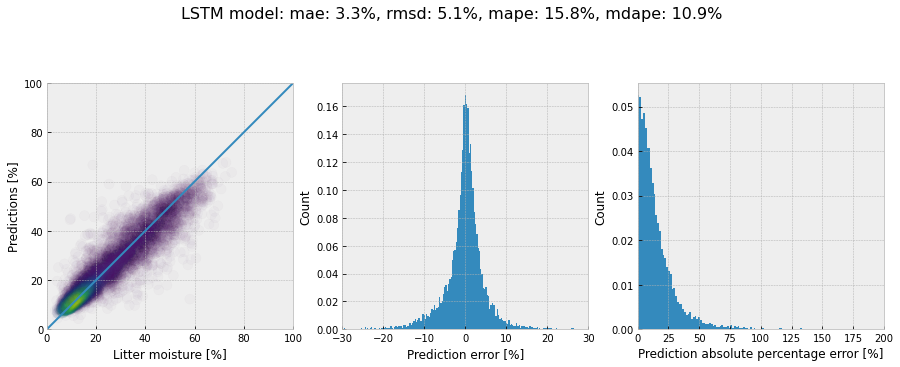

In [16]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"LSTM model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_lstm_test_stats2.svg")

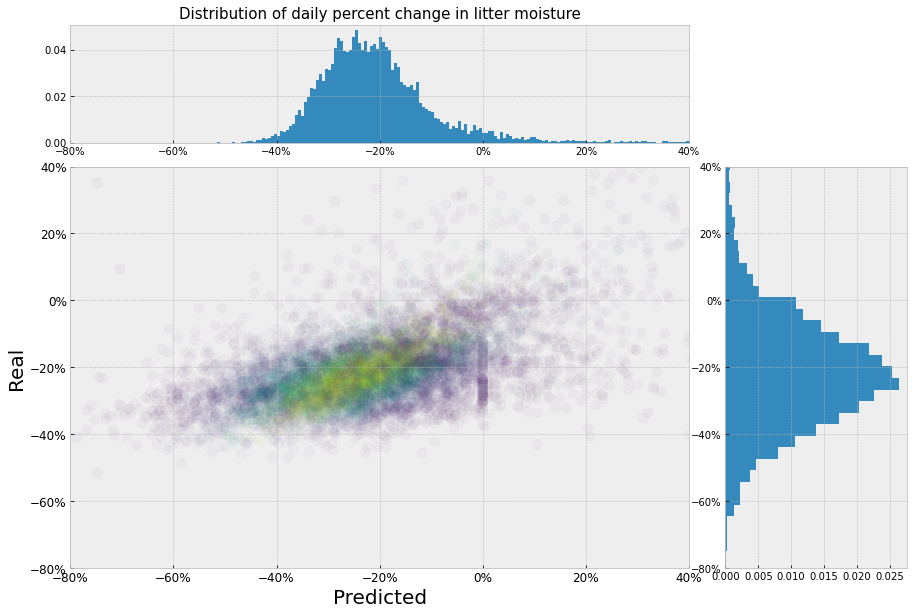

<Figure size 1080x720 with 0 Axes>

In [17]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(pct_change_test, pct_change_predicted, c=z, s=100, alpha=0.03)
ax_hist_x.hist(pct_change_test, orientation="horizontal", bins=150, density=True)
ax_hist_y.hist(pct_change_predicted, bins=500, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_ylabel("Real", fontsize=20)
ax_scatter.set_xlabel("Predicted", fontsize=20)

min_val, max_val = -80, 40
ax_scatter.set_xlim([min_val, max_val])
ax_scatter.set_ylim([min_val, max_val])
ax_hist_y.set_xlim([min_val, max_val])
ax_hist_x.set_ylim([min_val, max_val])
# ax_scatter.set_aspect(1)
ax_hist_y.set_title(
    "Distribution of daily percent change in litter moisture", fontsize=15
)
ax_scatter.tick_params(axis="both", which="major", labelsize=12)
ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.show()
plt.savefig("results_boundary_pct_change_distribution_lstm3.svg")

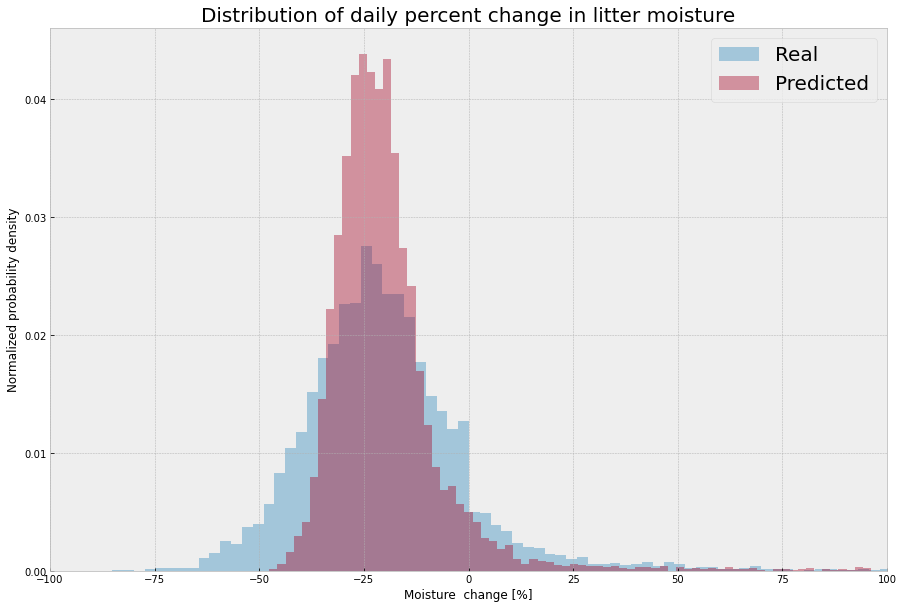

In [21]:
_ = plt.hist(pct_change_test, bins=200, density=True, alpha=0.4, label="Real")
_ = plt.hist(pct_change_predicted, bins=150, density=True, alpha=0.4, label="Predicted")
plt.legend(fontsize=20)
plt.xlim([-100, 100])
plt.xlabel("Moisture  change [%]")
plt.ylabel("Normalized probability density")
_ = plt.title("Distribution of daily percent change in litter moisture", fontsize=20)